In [1]:
# pip install geopandas contextily
# pip install --upgrade contextily
# pip install folium pandas

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
df = pd.read_csv('./data/output/result_gemeente.csv')

# Review data

## 0. Drop rows with some outlier values
- Rows with empty bathroom value is always have empty values in amenities columns, so it makes sense to drop them
- We drop properties with price more than 1000 euro per night as they are quite rare and we can count them as outliers
- Same for propries with more than 500 reviews, there are only 100 of them and we drop them
- We have only one property in postcodes 1037 and 1042, so we can safely drop them

In [4]:
df = df.dropna(subset=['bathrooms'])
df = df[df["amenities"] != '[]']
df = df[df["price"] < 1000]
df = df[df["number_of_reviews"] < 500]
df = df[df["postcode"] != 1037]
df = df[df["postcode"] != 1042]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6505 entries, 0 to 7149
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6505 non-null   int64  
 1   last_scraped                 6505 non-null   object 
 2   host_id                      6505 non-null   int64  
 3   host_since                   6505 non-null   object 
 4   host_is_superhost            6505 non-null   object 
 5   neighbourhood_cleansed       6505 non-null   object 
 6   host_listings_count          6505 non-null   int64  
 7   latitude                     6505 non-null   float64
 8   longitude                    6505 non-null   float64
 9   property_type                6505 non-null   object 
 10  room_type                    6505 non-null   object 
 11  accommodates                 6505 non-null   int64  
 12  bathrooms                    6505 non-null   float64
 13  bathrooms_text         

## 1. Host since
- We might convert it to number of years on the platform and use as numerical features.

In [6]:
df["host_since"].head(2)

0    2008-09-24
2    2010-03-23
Name: host_since, dtype: object

In [7]:
# Convert to date
df['host_since'] = pd.to_datetime(df['host_since'])

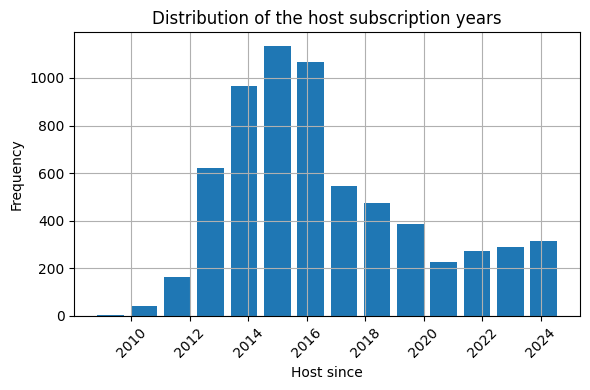

In [8]:
plt.figure(figsize=(6, 4))
df['host_since'].hist(bins=14, rwidth=0.8)
plt.title('Distribution of the host subscription years')
plt.xlabel('Host since')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Superhost

In [9]:
# Replace t/f with 1/0
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})

In [10]:
df["host_is_superhost"].head(2)

0    1
2    1
Name: host_is_superhost, dtype: int64

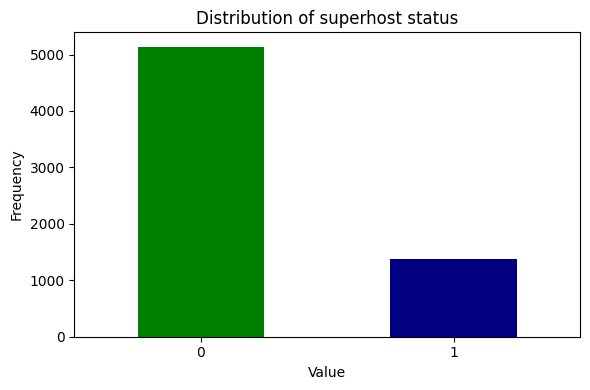

In [11]:
# Plot count for 1 and 0
value_counts = df['host_is_superhost'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of superhost status')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Host listing count
- We might want to convert this feature to binary feature: single property host vs multi property host

In [12]:
df["host_listings_count"].head(2)

0    1
2    1
Name: host_listings_count, dtype: int64

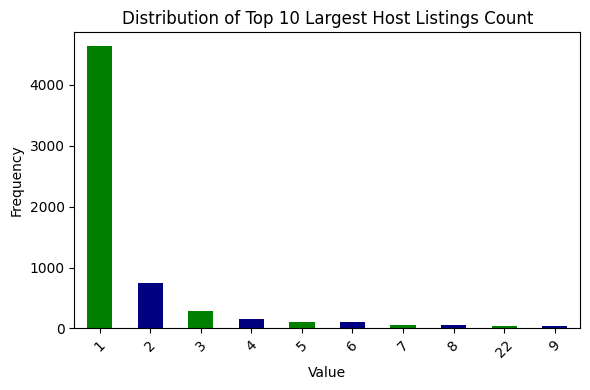

In [13]:
value_counts = df['host_listings_count'].value_counts()
top_10_value_counts = value_counts.sort_values(ascending=False).head(10)
plt.figure(figsize=(6, 4))
top_10_value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of Top 10 Largest Host Listings Count')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Properties on the map
- As expected city center is quite densely covered in properties

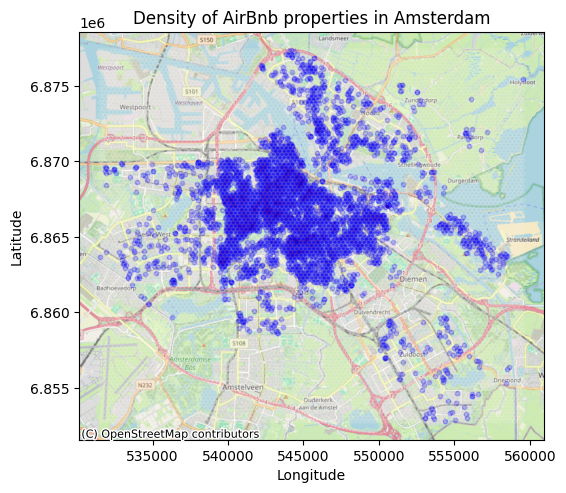

In [14]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857) for plotting with contextily
gdf = gdf.to_crs(epsg=3857)

# Plot the density of points
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax, alpha=0.3, markersize=10, color='blue')

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Create a hexbin plot to show density
plt.hexbin(gdf.geometry.x, gdf.geometry.y, gridsize=100, cmap='OrRd', alpha=0.1)

# Set plot title and labels
plt.title('Density of AirBnb properties in Amsterdam')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## 5. Property types
- We have quite some different types of properties (57), I propose to group depending on whether it's whole property or room for rent

In [15]:
df['property_type'].value_counts()

property_type
Entire rental unit                    2621
Entire condo                          1015
Entire home                            633
Private room in rental unit            379
Private room in bed and breakfast      297
Entire loft                            158
Private room in condo                  156
Room in hotel                          143
Private room in home                   136
Entire serviced apartment              118
Houseboat                              106
Entire townhouse                       105
Boat                                    83
Private room in houseboat               77
Room in boutique hotel                  64
Private room in townhouse               56
Private room in guest suite             53
Private room in boat                    33
Private room in loft                    31
Entire guest suite                      28
Entire guesthouse                       24
Private room in guesthouse              20
Room in bed and breakfast               

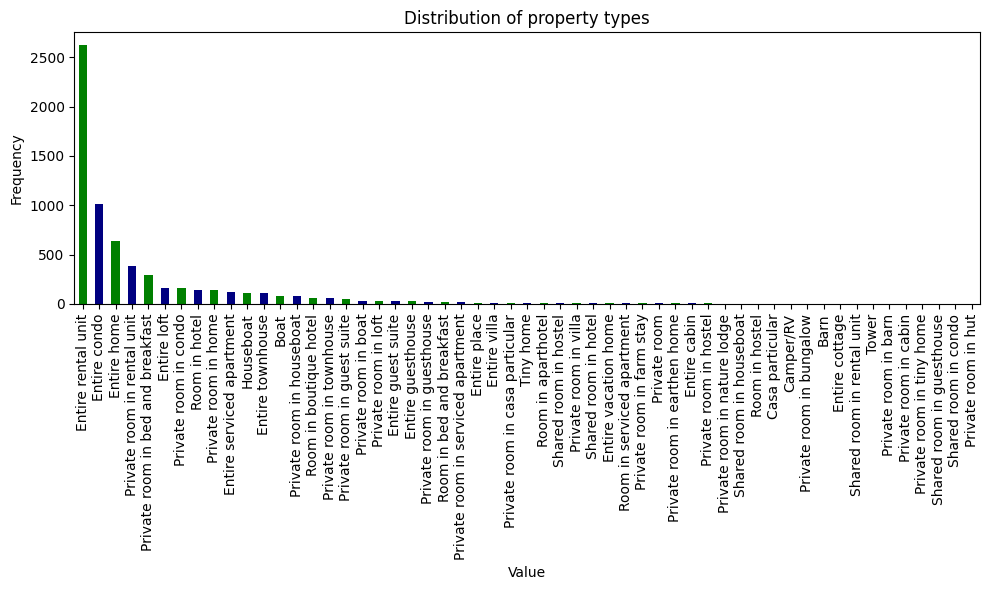

In [16]:
value_counts = df['property_type'].value_counts()
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of property types')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5.1 Groupping property types to two categories: Full property or Private room

In [17]:
# Define mapping for property types
mapping = {
    'Entire rental unit': 'Full property',
    'Entire condo': 'Full property',
    'Entire home': 'Full property',
    'Entire loft': 'Full property',
    'Entire serviced apartment': 'Full property',
    'Entire townhouse': 'Full property',
    'Entire guest suite': 'Full property',
    'Entire guesthouse': 'Full property',
    'Entire villa': 'Full property',
    'Entire place': 'Full property',
    'Entire vacation home': 'Full property',
    'Entire cabin': 'Full property',
    'Entire cottage': 'Full property',
    'Houseboat': 'Full property',
    'Boat': 'Full property',
    'Tiny home': 'Full property',
    'Camper/RV': 'Full property',
    'Barn': 'Full property',
    'Tower': 'Full property',
    'Shipping container': 'Full property',
    'Casa particular': 'Full property',
    'Private room in rental unit': 'Private room',
    'Private room in bed and breakfast': 'Private room',
    'Private room in condo': 'Private room',
    'Room in hotel': 'Private room',
    'Private room in home': 'Private room',
    'Private room in houseboat': 'Private room',
    'Room in boutique hotel': 'Private room',
    'Private room in guest suite': 'Private room',
    'Private room in townhouse': 'Private room',
    'Private room in boat': 'Private room',
    'Private room in loft': 'Private room',
    'Private room in guesthouse': 'Private room',
    'Room in bed and breakfast': 'Private room',
    'Private room in serviced apartment': 'Private room',
    'Private room in casa particular': 'Private room',
    'Room in aparthotel': 'Private room',
    'Shared room in hostel': 'Private room',
    'Shared room in hotel': 'Private room',
    'Private room in villa': 'Private room',
    'Room in serviced apartment': 'Private room',
    'Private room in hostel': 'Private room',
    'Private room in farm stay': 'Private room',
    'Private room in earthen home': 'Private room',
    'Private room': 'Private room',
    'Private room in nature lodge': 'Private room',
    'Shared room in houseboat': 'Private room',
    'Room in hostel': 'Private room',
    'Private room in bungalow': 'Private room',
    'Private room in tiny home': 'Private room',
    'Shared room in rental unit': 'Private room',
    'Private room in cabin': 'Private room',
    'Shared room in bed and breakfast': 'Private room',
    'Private room in barn': 'Private room',
    'Shared room in guesthouse': 'Private room',
    'Shared room in condo': 'Private room',
    'Private room in hut': 'Private room'
}

# Map the property types to the new categories
df['property_category'] = df['property_type'].replace(mapping)

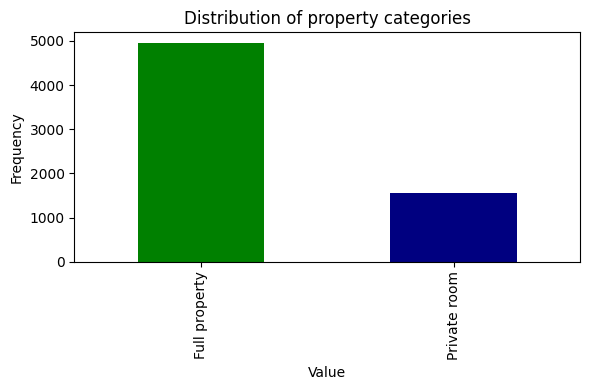

In [18]:
value_counts = df['property_category'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of property categories')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 6. How many people can be accommodated in property

In [19]:
df["accommodates"].head()

0    2
2    2
6    4
7    5
8    2
Name: accommodates, dtype: int64

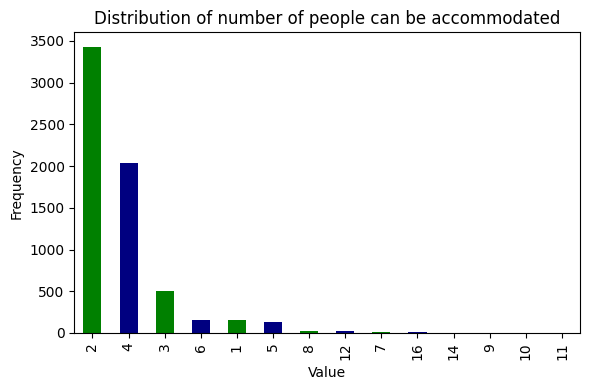

In [20]:
value_counts = df['accommodates'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of number of people can be accommodated')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 7. Number of bathrooms

In [21]:
df[["bathrooms"]].head(5)

,bathrooms
0,1.5
2,1.5
6,1.5
7,1.5
8,1.0


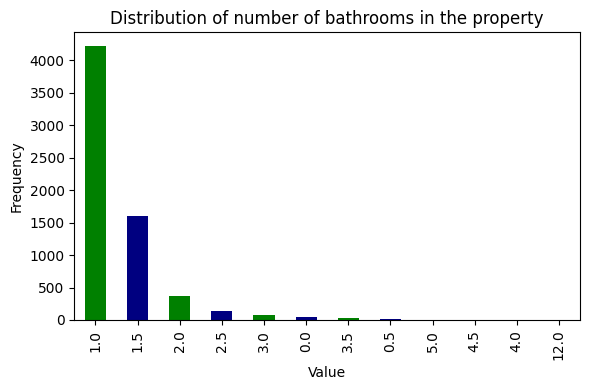

In [22]:
value_counts = df['bathrooms'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of number of bathrooms in the property')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 8. Bedrooms

In [23]:
df["bedrooms"].head()

0    1.0
2    1.0
6    2.0
7    3.0
8    1.0
Name: bedrooms, dtype: float64

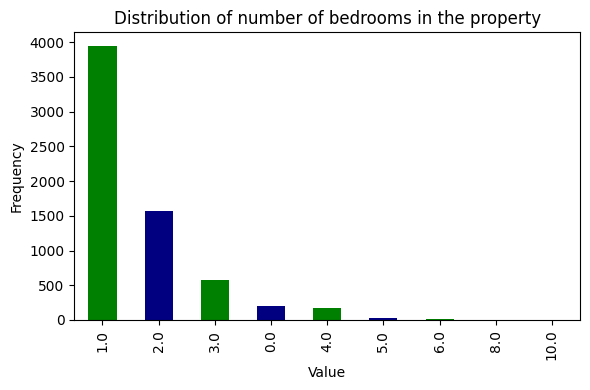

In [24]:
value_counts = df['bedrooms'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of number of bedrooms in the property')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 9. Beds

In [25]:
df["beds"].head()

0    2.0
2    1.0
6    3.0
7    3.0
8    1.0
Name: beds, dtype: float64

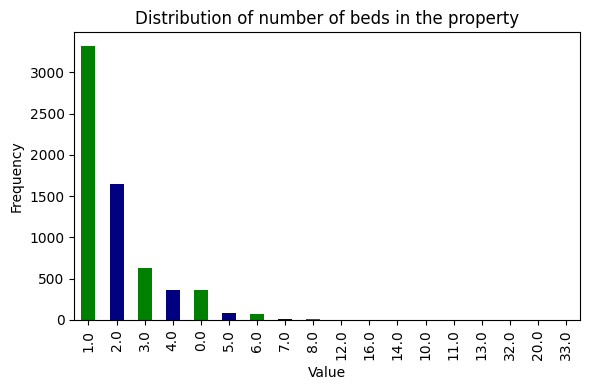

In [26]:
value_counts = df['beds'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of number of beds in the property')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 10. Price
- We have some small number of price outliers and we will drop them

In [27]:
df["price"].head()

0     83.0
2    155.0
6    475.0
7    130.0
8    139.0
Name: price, dtype: float64

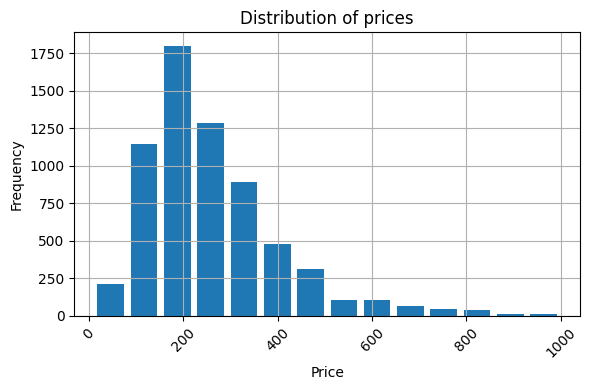

In [28]:
plt.figure(figsize=(6, 4))
df['price'].hist(bins=14, rwidth=0.8)
plt.title('Distribution of prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Number of reviews

In [29]:
df["number_of_reviews"].head()

0    389
2    279
6    163
7     17
8    484
Name: number_of_reviews, dtype: int64

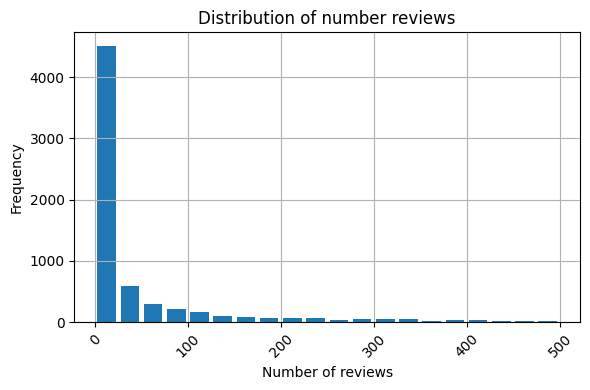

In [30]:
plt.figure(figsize=(6, 4))
df['number_of_reviews'].hist(bins=20, rwidth=0.8)
plt.title('Distribution of number reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 12. Reviews
- Distribution of reviews is very interesting, with a bunch of reviews around 0 and most grouped close to 5

In [31]:
df["review_scores_rating"].head()

0    4.90
2    4.92
6    4.87
7    4.76
8    4.88
Name: review_scores_rating, dtype: float64

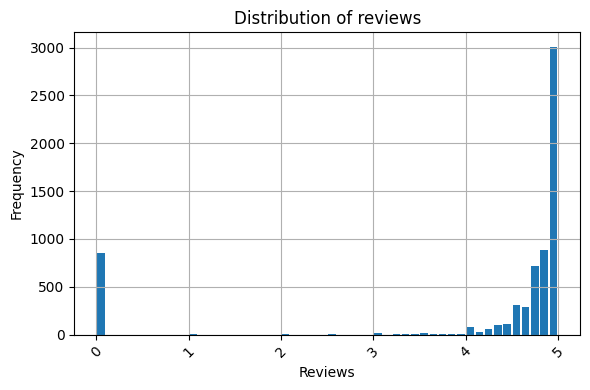

In [32]:
plt.figure(figsize=(6, 4))
df['review_scores_rating'].hist(bins=50, rwidth=0.8)
plt.title('Distribution of reviews')
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 13. Amenities

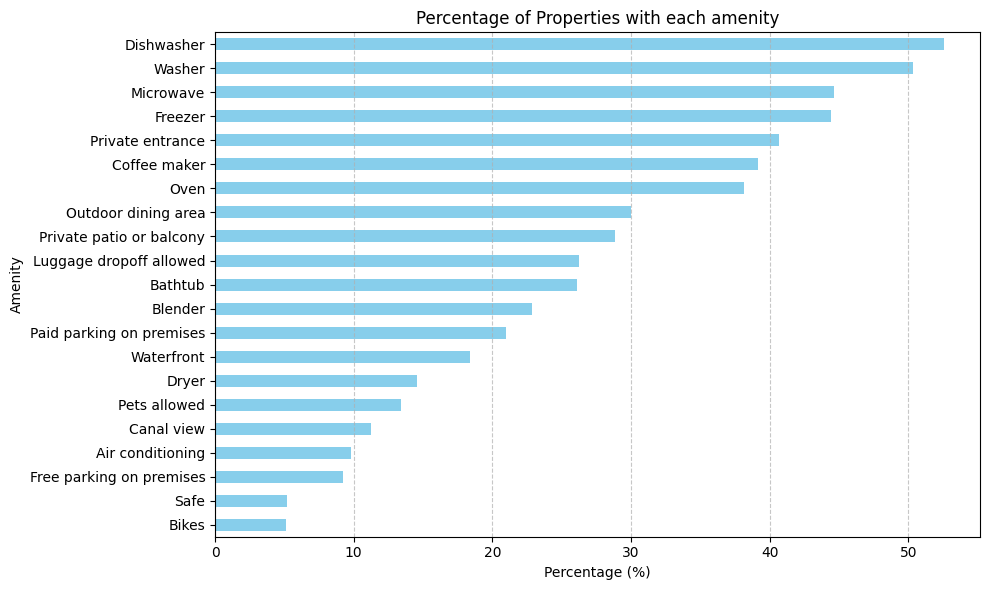

In [33]:
binary_columns = ['Dishwasher', 'Washer', 'Dryer', 'Microwave', 'Freezer', 'Private entrance',
                  'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
                  'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
                  'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view',
                  'Free parking on premises', 'Bikes', 'Safe']

percentages = df[binary_columns].mean() * 100

plt.figure(figsize=(10, 6))
percentages.sort_values().plot(kind='barh', color='skyblue')
plt.title('Percentage of Properties with each amenity')
plt.xlabel('Percentage (%)')
plt.ylabel('Amenity')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 14. Instant bookable

In [34]:
# Replace t/f with 1/0
df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

In [35]:
df["instant_bookable"].head()

0    0
2    0
6    0
7    0
8    0
Name: instant_bookable, dtype: int64

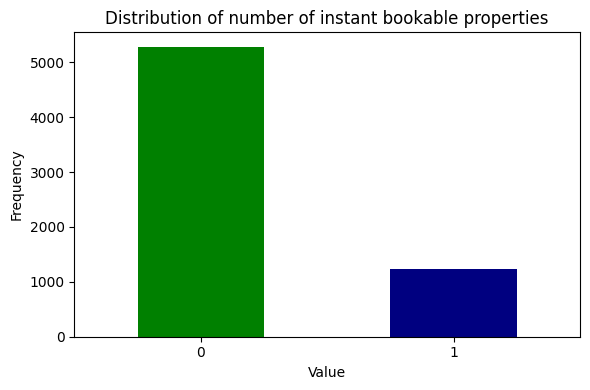

In [36]:
value_counts = df['instant_bookable'].value_counts()
plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color=['green', 'navy'])
plt.title('Distribution of number of instant bookable properties')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 15. Postcodes

### 15.1 Average price per postcode

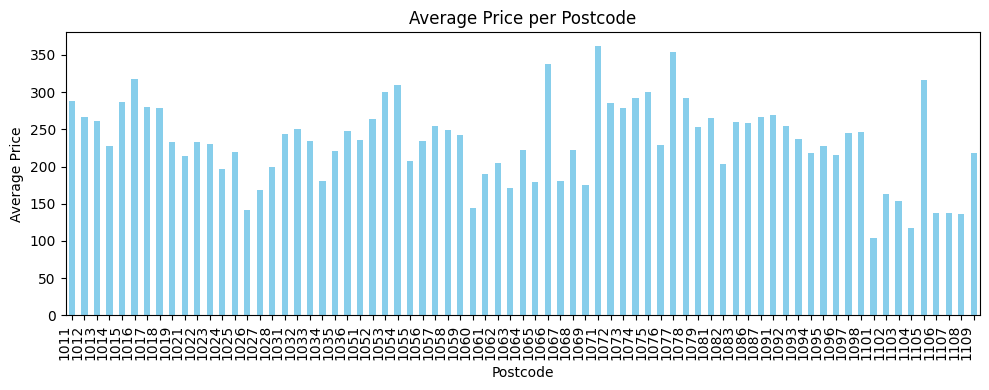

In [37]:
average_price = df.groupby('postcode')['price'].mean()

plt.figure(figsize=(10, 4))
average_price.plot(kind='bar', color='skyblue')
plt.title('Average Price per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Average Price')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### 15.2 Number of listings per postcode


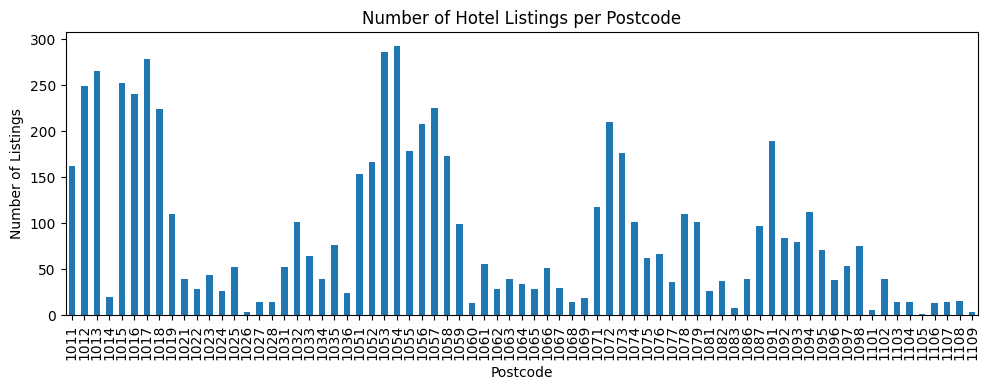

In [38]:
# Group by postcode and count the number of listings
postcode_counts = df['postcode'].value_counts()

# Sort the Series by index (postcode)
postcode_counts = postcode_counts.sort_index()

plt.figure(figsize=(10, 4))
postcode_counts.plot(kind='bar')
plt.title('Number of Hotel Listings per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 15.3 Number of residents per postcode

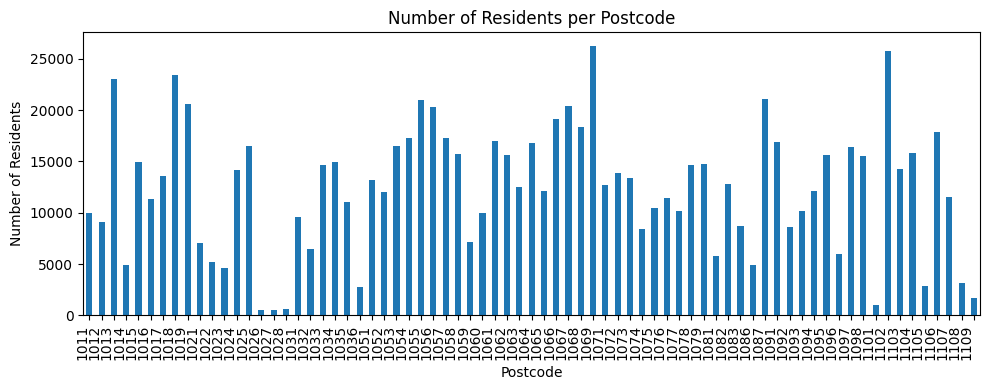

In [39]:
# Drop duplicate postcodes, keeping the first occurrence
df_unique = df.drop_duplicates(subset='postcode')

# Sort the DataFrame by postcode for ordered plotting
df_sorted = df_unique.sort_values(by='postcode')

# Set the postcode as the index
df_sorted.set_index('postcode', inplace=True)

plt.figure(figsize=(10, 4))
df_sorted['inwoners'].plot(kind='bar')
plt.title('Number of Residents per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Number of Residents')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### 15.4 Rent vs owned houses per postcode

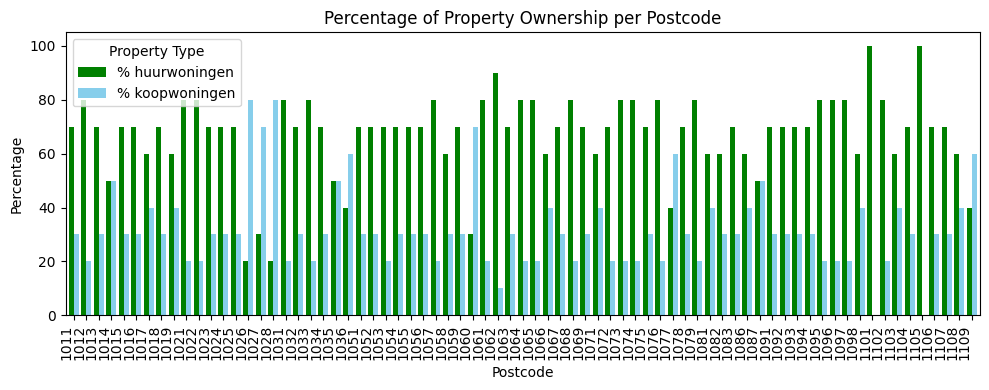

In [40]:
# Select only the relevant columns
df_selected = df.drop_duplicates(subset='postcode').sort_values(by='postcode')[['postcode', '% huurwoningen', '% koopwoningen']]

# Convert percentage strings to numeric values
df_selected['% huurwoningen'] = df_selected['% huurwoningen'].str.rstrip('%').astype(float)
df_selected['% koopwoningen'] = df_selected['% koopwoningen'].str.rstrip('%').astype(float)
df_selected.set_index('postcode', inplace=True)

plt.figure(figsize=(10, 4))
df_selected.plot(kind='bar', color=['green', 'skyblue'], width=0.8, ax=plt.gca())
plt.title('Percentage of Property Ownership per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Percentage')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Property Type')
plt.tight_layout()
plt.show()

### 15.5 Average house price per postcode

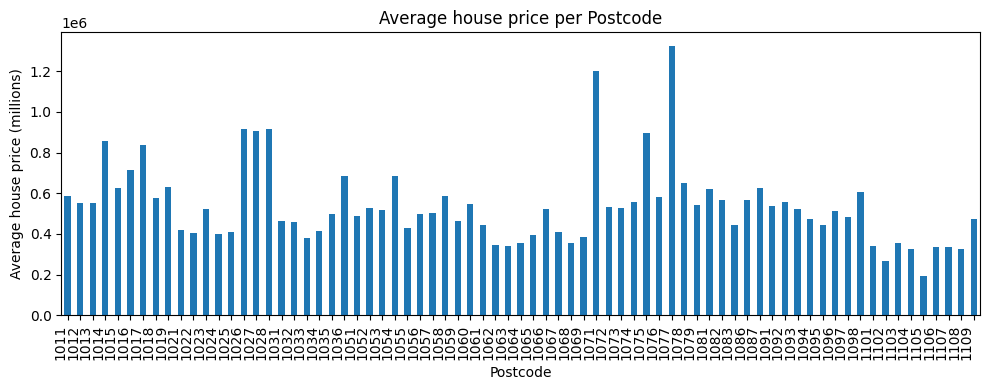

In [41]:
# Drop duplicate postcodes, keeping the first occurrence
df_unique = df.drop_duplicates(subset='postcode')

# Sort the DataFrame by postcode for ordered plotting
df_sorted = df_unique.sort_values(by='postcode')
df_sorted.set_index('postcode', inplace=True)

plt.figure(figsize=(10, 4))
df_sorted['gemiddelde woningwaarde'].plot(kind='bar')
plt.title('Average house price per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Average house price (millions)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### 15.5 Distance to different facilities


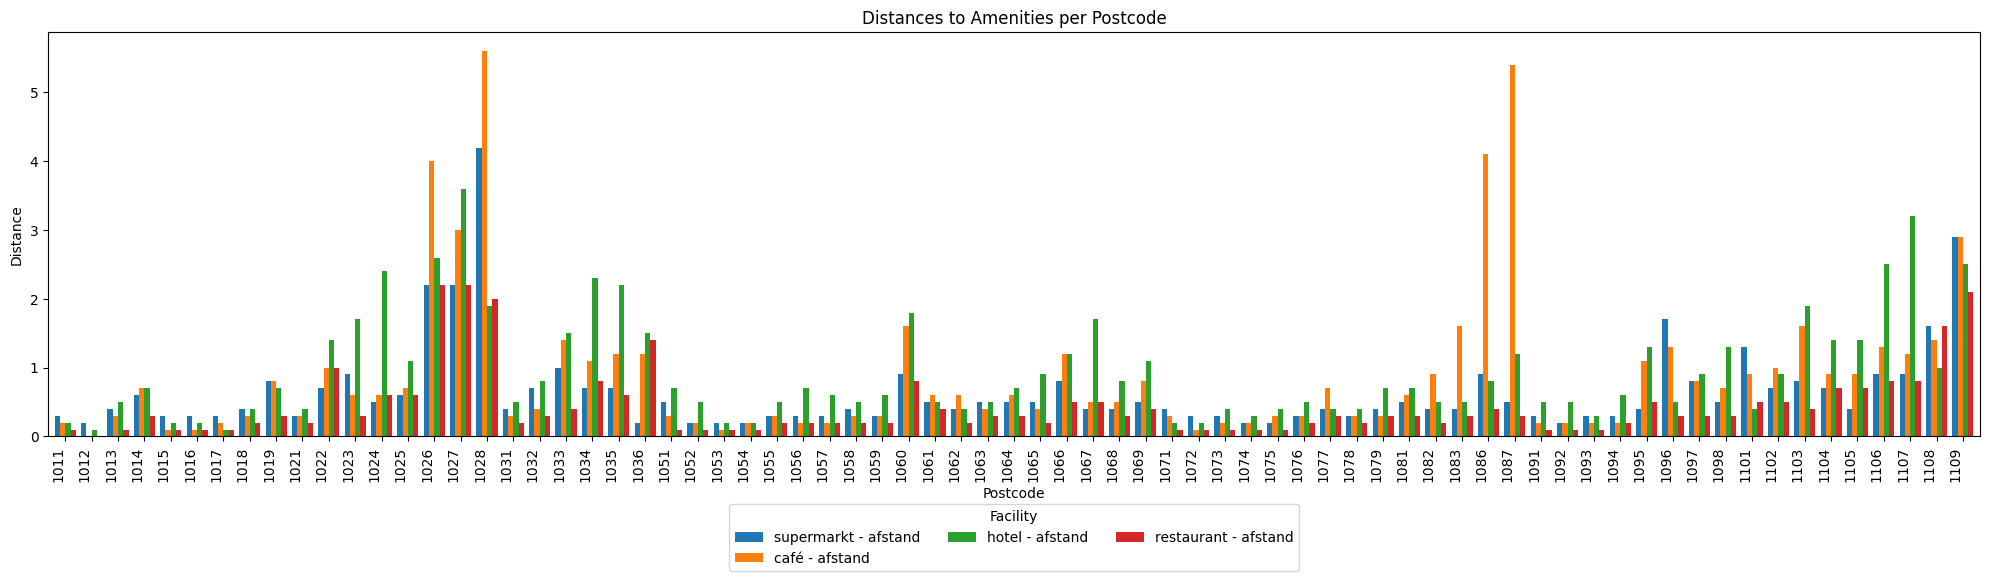

In [42]:
distance_columns = [
    'supermarkt - afstand', 'café - afstand', 'hotel - afstand', 'restaurant - afstand'
]

# Drop duplicate postcodes, keeping the first occurrence
df_unique = df.drop_duplicates(subset='postcode')

# Sort the DataFrame by postcode for ordered plotting
df_sorted = df_unique.sort_values(by='postcode')
df_sorted.set_index('postcode', inplace=True)

for column in distance_columns:
    df_sorted[column] = df_sorted[column].str.replace(',', '.').astype(float)

# Plot the results
plt.figure(figsize=(20, 6))
df_sorted[distance_columns].plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Distances to Amenities per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Distance')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Facility', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

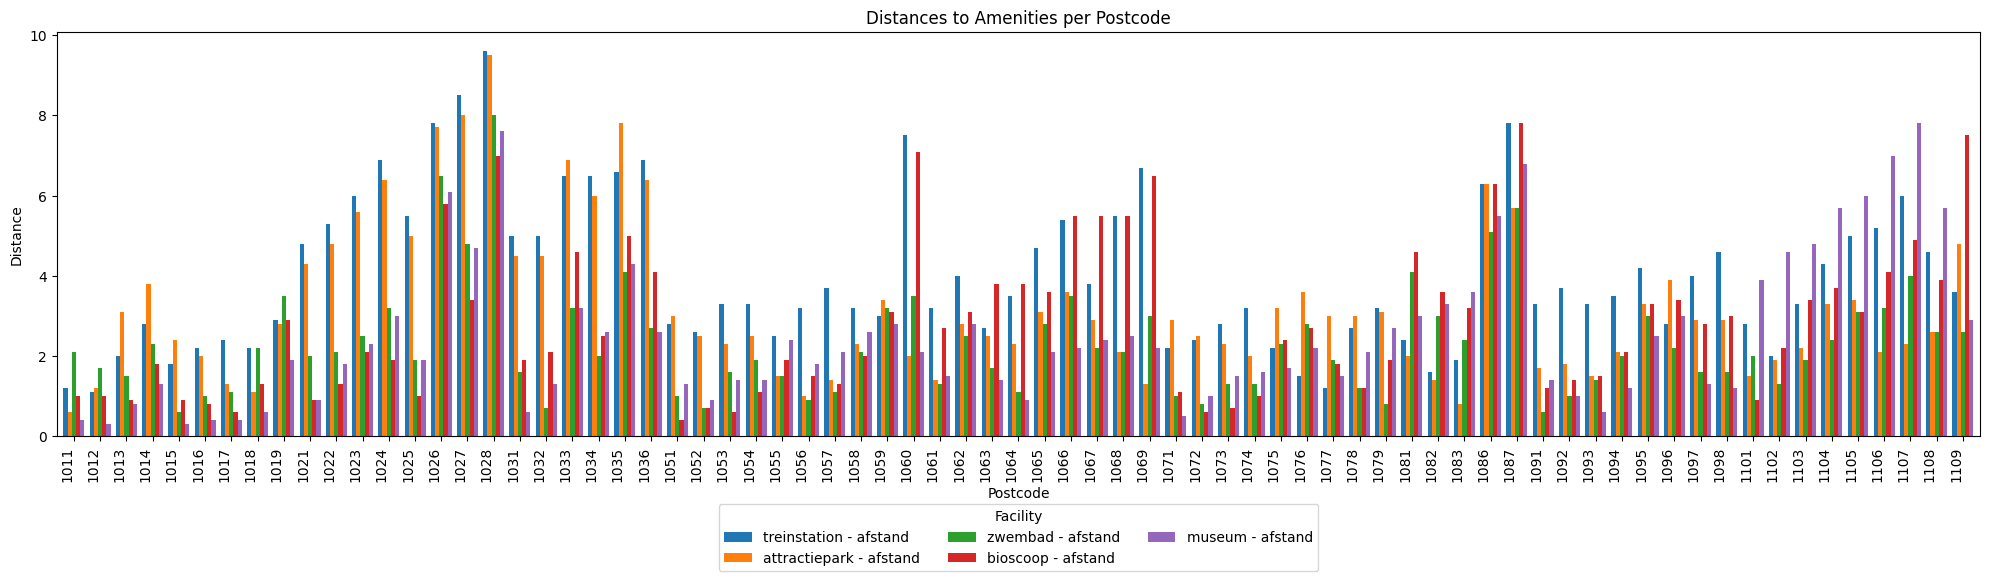

In [43]:
distance_columns = [
   'treinstation - afstand', 'attractiepark - afstand', 'zwembad - afstand', 'bioscoop - afstand', 'museum - afstand'
]

# Drop duplicate postcodes, keeping the first occurrence
df_unique = df.drop_duplicates(subset='postcode')

# Sort the DataFrame by postcode for ordered plotting
df_sorted = df_unique.sort_values(by='postcode')
df_sorted.set_index('postcode', inplace=True)

for column in distance_columns:
    df_sorted[column] = df_sorted[column].str.replace(',', '.').astype(float)

# Plot the results
plt.figure(figsize=(20, 6))
df_sorted[distance_columns].plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Distances to Amenities per Postcode')
plt.xlabel('Postcode')
plt.ylabel('Distance')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Facility', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()